<h1 style="text-align:center;"><b>Laboratorio 1</b></h1>
<h3 style="text-align:center;">Alina Carías (22539), Ariela Mishaan (22052), Marcos Díaz (221102) </h3>

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX



## Importar datos

In [3]:
#CONSUMO

archivo = 'Datos/Consumo.xlsx'
df = pd.read_excel(archivo)
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%Y-%m')
df.set_index('Fecha', inplace=True)

#Se saca las columnas necesarias
columnas_deseadas = ['Gasolina superior', 'Gasolina regular', 'Diesel alto azufre']
consumo = df[columnas_deseadas]
print('\nDatos filtrados:')
consumo.head()


Datos filtrados:


,Gasolina superior,Gasolina regular,Diesel alto azufre
Fecha,,,
2000-01-01,308156.82,202645.20,634667.06
2000-02-01,307766.31,205530.96,642380.66
2000-03-01,331910.29,229499.56,699807.25
2000-04-01,315648.08,210680.40,586803.98
2000-05-01,319667.97,208164.34,656948.20


In [4]:
#IMPORTACIONES

archivo = 'Datos/Importaciones.xlsx'
df = pd.read_excel(archivo)
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%Y-%m')
df.set_index('Fecha', inplace=True)

#Se saca las columnas necesarias
columnas_deseadas = ['Gasolina superior', 'Gasolina regular', 'Diesel alto azufre']
importaciones = df[columnas_deseadas]
print('\nDatos filtrados:')
importaciones.head()


Datos filtrados:


,Gasolina superior,Gasolina regular,Diesel alto azufre
Fecha,,,
2001-01-01,373963.96,177776.50,566101.99
2001-02-01,243091.07,123115.99,489525.80
2001-03-01,312084.38,161726.42,575559.68
2001-04-01,285054.89,127338.74,437745.42
2001-05-01,300913.67,168730.19,552609.13


## Convertir en series de tiempo

In [5]:
#Gasolina superior
ts_consumo_superior = consumo['Gasolina superior']
ts_importa_superior = importaciones['Gasolina superior']

#Gasolina regular
ts_consumo_regular = consumo['Gasolina regular']
ts_importa_regular = importaciones['Gasolina regular']

#Diesel alto azufre
ts_consumo_diesel = consumo['Diesel alto azufre']
ts_importa_diesel = importaciones['Diesel alto azufre']

## Análisis exploratorio

In [6]:
print("Consumo")
print(ts_consumo_superior.describe(),ts_consumo_regular.describe(),ts_consumo_diesel.describe())

print("\nImportaciones")
print( ts_importa_superior.describe(),  ts_importa_regular.describe(),  ts_importa_diesel.describe())

Consumo
count       300.000000
mean     470248.678849
std      113504.653305
min      300242.781667
25%      383931.904375
50%      423319.540000
75%      573704.195000
max      786598.120000
Name: Gasolina superior, dtype: float64 count       300.000000
mean     397478.894458
std      219102.049432
min      160741.900000
25%      215650.312917
50%      288193.130000
75%      548073.682500
max      938086.570000
Name: Gasolina regular, dtype: float64 count    3.000000e+02
mean     5.144313e+05
std      3.688977e+05
min      0.000000e+00
25%      0.000000e+00
50%      6.721700e+05
75%      7.791021e+05
max      1.149175e+06
Name: Diesel alto azufre, dtype: float64

Importaciones
count    2.880000e+02
mean     4.909544e+05
std      1.565581e+05
min      1.702925e+05
25%      3.693299e+05
50%      4.813002e+05
75%      6.083053e+05
max      1.227174e+06
Name: Gasolina superior, dtype: float64 count    2.880000e+02
mean     4.129493e+05
std      2.432627e+05
min      8.101530e+04
25%      

Se puede ver que la gasolina Diesel tiene la media de consumo más alta (735 000), casi el doble de la media de consumo de la gasolina superior (420 000). A su vez, la gasolina superior tiene una media de consumo de casi el doble de la media de la gasolina regular (270 000). La desviación estándar coincide en las diferencias (es decir, el diesel tiene la desviación más grande, seguido de superior y por último regular). 

En cuanto a las importaciones, se mantiene el orden. Se puede ver que la gasolina tiene uan media de importación de alrededor de 800 000, mientras que la gasdolina superior tiene una de alrededor de 430 000. El promedio de importaciones de la gaslolina regular es de alrededor 280 000. 

Se puede observar que el valor de la media consumo medio es alrededor de 10 000 menor que las importaciones.

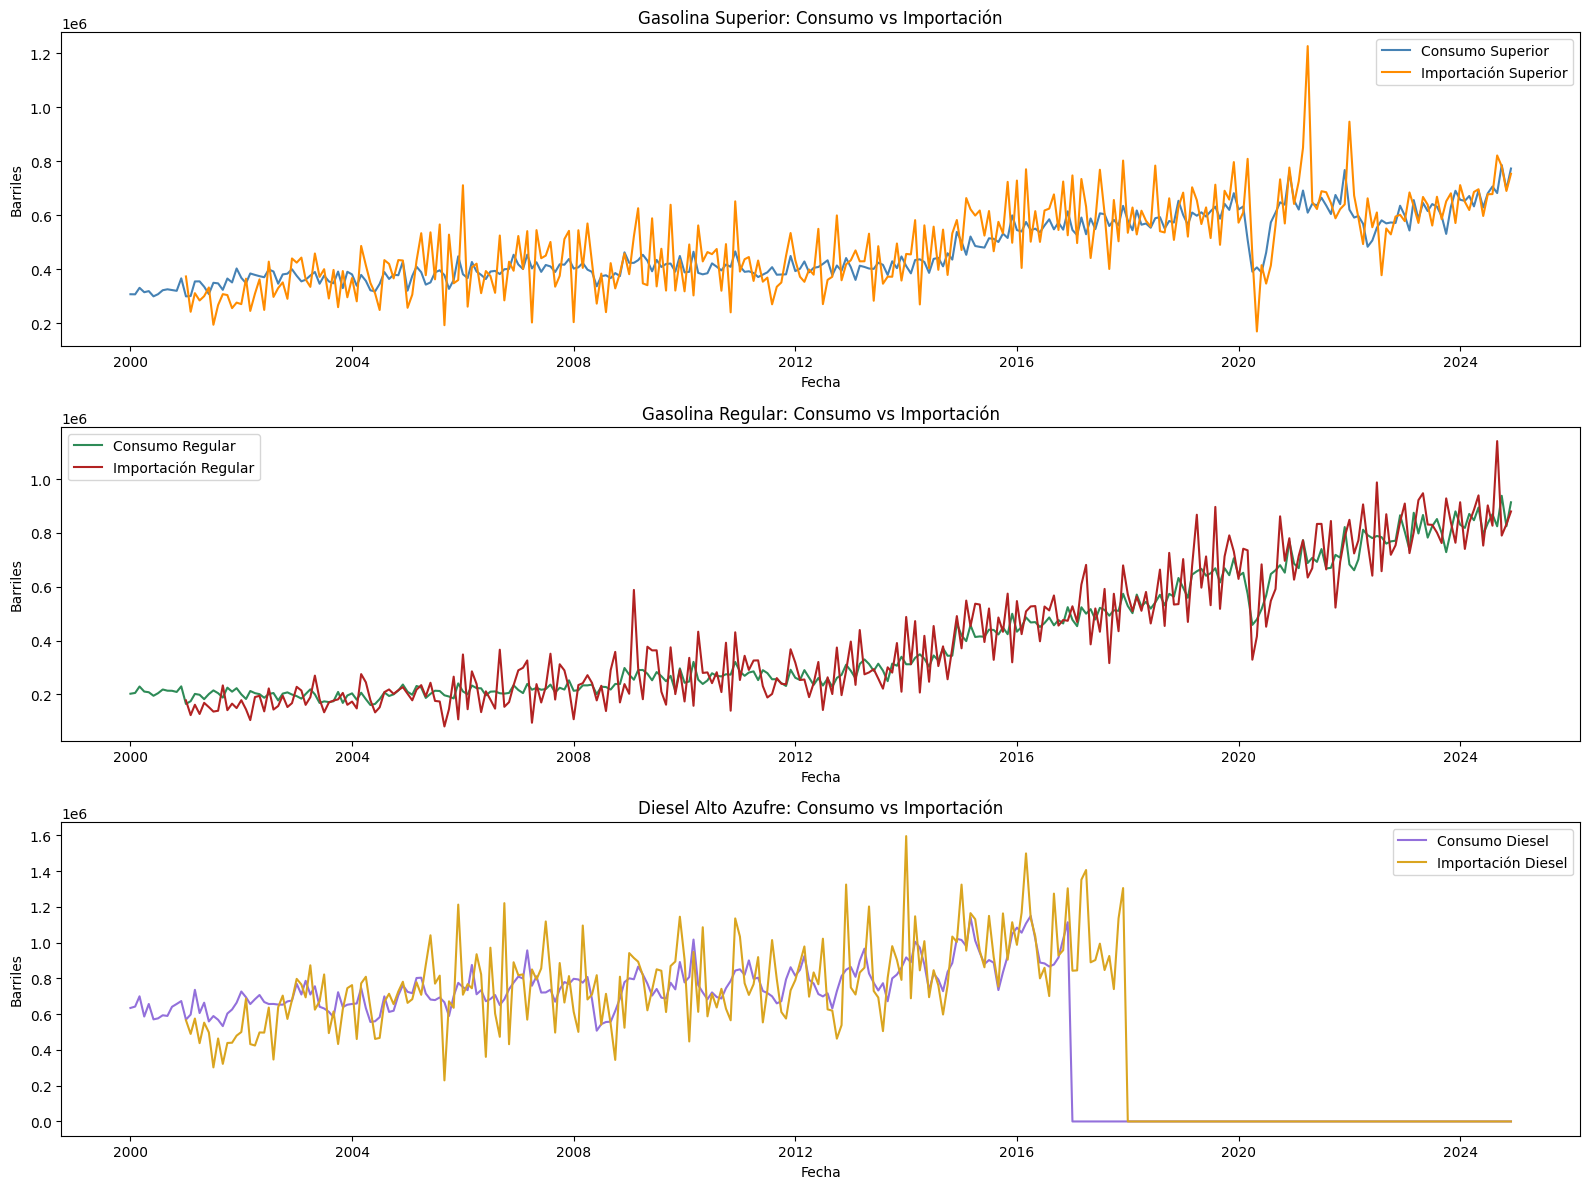

In [7]:
#Gasolina Superior
plt.figure(figsize=(16, 12))
plt.subplot(3, 1, 1)
plt.plot(ts_consumo_superior, label='Consumo Superior', color='steelblue')
plt.plot(ts_importa_superior, label='Importación Superior', color='darkorange')
plt.title('Gasolina Superior: Consumo vs Importación')
plt.xlabel('Fecha')
plt.ylabel('Barriles')
plt.legend()

#Gasolina Regular
plt.subplot(3, 1, 2)
plt.plot(ts_consumo_regular, label='Consumo Regular', color='seagreen')
plt.plot(ts_importa_regular, label='Importación Regular', color='firebrick')
plt.title('Gasolina Regular: Consumo vs Importación')
plt.xlabel('Fecha')
plt.ylabel('Barriles')
plt.legend()

#Diesel Alto Azufre
plt.subplot(3, 1, 3)
plt.plot(ts_consumo_diesel, label='Consumo Diesel', color='mediumpurple')
plt.plot(ts_importa_diesel, label='Importación Diesel', color='goldenrod')
plt.title('Diesel Alto Azufre: Consumo vs Importación')
plt.xlabel('Fecha')
plt.ylabel('Barriles')
plt.legend()
plt.tight_layout()
plt.show()

### Análisis de normalidad

In [8]:
from scipy.stats import shapiro
stat1, p1 = shapiro(ts_consumo_superior)
stat2, p2 = shapiro(ts_importa_superior)
stat3, p3 = shapiro(ts_consumo_regular)
stat4, p4 = shapiro(ts_importa_regular)
stat5, p5 = shapiro(ts_consumo_diesel)
stat6, p6 = shapiro(ts_importa_diesel)

print(p1, p2, p3, p4, p5, p6)

3.506804326490063e-12 3.9058785496496804e-05 1.140071930723717e-16 1.6854999268180919e-12 9.372158444314666e-19 5.238734057074212e-13


El valor-p es menor a 0.05 para todas las variables, lo que indica que todas estan distribuidas normalmente

### Meses en los que más importaciones hay

In [9]:
meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

promedio_consumo_superior = ts_consumo_superior.groupby(ts_consumo_superior.index.month).mean()
promedio_consumo_superior.index = meses
print('Consumo\n')
print(promedio_consumo_superior)

promedio_consumo_regular = ts_consumo_regular.groupby(ts_consumo_regular.index.month).mean()
promedio_consumo_regular.index = meses
print(promedio_consumo_regular)

promedio_consumo_diesel = ts_consumo_diesel.groupby(ts_consumo_diesel.index.month).mean()
promedio_consumo_diesel.index = meses
print(promedio_consumo_diesel)

print('\nImportaciones')

promedio_importa_superior = ts_importa_superior.groupby(ts_importa_superior.index.month).mean()
promedio_importa_superior.index = meses
print(promedio_importa_superior)

promedio_importa_regular = ts_importa_regular.groupby(ts_importa_regular.index.month).mean()
promedio_importa_regular.index = meses
print(promedio_importa_regular)

promedio_importa_diesel = ts_importa_diesel.groupby(ts_importa_diesel.index.month).mean()
promedio_importa_diesel.index = meses
print(promedio_importa_diesel)

Consumo

Enero         465444.133900
Febrero       449589.379500
Marzo         485997.725420
Abril         454148.854300
Mayo          455444.417900
Junio         437856.819500
Julio         471367.123900
Agosto        478979.751100
Septiembre    456616.414433
Octubre       481344.612300
Noviembre     469803.929900
Diciembre     536390.984033
Name: Gasolina superior, dtype: float64
Enero         383185.687333
Febrero       369956.867333
Marzo         411988.348533
Abril         394359.671433
Mayo          393026.630933
Junio         378066.094133
Julio         398433.337333
Agosto        402503.807333
Septiembre    385355.633152
Octubre       405274.873333
Noviembre     394711.527933
Diciembre     452884.254705
Name: Gasolina regular, dtype: float64
Enero         542594.861848
Febrero       534185.231238
Marzo         595864.636895
Abril         543003.669910
Mayo          520845.624667
Junio         467567.321829
Julio         475682.383192
Agosto        478067.624152
Septiembre    44

Se puede observar que aunque el cambio no es tan signficativo si existen diferencias por mes. Por ejemplo, el consumo de gasolina sin importar el tipo es mas alto en diciembre y bajo en febrero. Para las importaciones el diesel tiene un valor mucho mas alto en diciembre, pero los demas tipos no demuestran tanta diferencia.

## Train y Test

In [ ]:
#Consumo
train_size_C = int(len(consumo) * 0.7)
train_c = consumo[0:train_size_C]
test_c = consumo[train_size_C:len(consumo)]

#Importaciones
train_size_I = int(len(importaciones) * 0.7)
train_i = importaciones[0:train_size_I]
test_i = importaciones[train_size_I:len(importaciones)]

### Análisis Preliminar Gasolina Superior

In [66]:
#Consumo
ts_consumo_superior = train_c['Gasolina superior']
ts_consumo_superior_test = train_c['Gasolina superior']

print('Consumo Gasolina Superior')
print('Frecuencia: MENSUAL')
print('\nInicio de la serie:',ts_consumo_superior.head(1))
print('\nFin de la serie:',ts_consumo_superior.tail(1))


#Importaciones
ts_importa_superior = train_i['Gasolina superior']
ts_importa_superior_test = train_i['Gasolina superior']

print('\nImportaciones Gasolina Superior')
print('Frecuencia: MENSUAL')
print('\nInicio de la serie', ts_importa_superior.head(1))
print('\nFin de la serie', ts_importa_superior.tail(1))



Consumo Gasolina Superior
Frecuencia: MENSUAL

Inicio de la serie: Fecha
2000-01-01    308156.82
Name: Gasolina superior, dtype: float64

Fin de la serie: Fecha
2017-06-01    549378.05
Name: Gasolina superior, dtype: float64

Importaciones Gasolina Superior
Frecuencia: MENSUAL

Inicio de la serie Fecha
2000-01-01    308156.82
Name: Gasolina superior, dtype: float64

Fin de la serie Fecha
2016-09-01    548491.65
Name: Gasolina superior, dtype: float64


### Análisis preliminar Diesel Azufre Alto

In [67]:
#Consumo
ts_consumo_diesel = train_c['Diesel alto azufre']
ts_consumo_diesel_test = test_c['Diesel alto azufre']

print('Consumo Gasolina Diesel Alto Azufre')
print('Frecuencia: MENSUAL')
print('\nInicio de la serie:',ts_consumo_diesel.head(1))
print('\nFin de la serie:',ts_consumo_diesel.tail(1))

#Impotaciones
ts_importa_diesel = train_i['Diesel alto azufre']
ts_importa_diesel_test = test_i['Diesel alto azufre']

print('\nImportaciones Gasolina Diesel Alto Azufre')
print('Frecuencia: MENSUAL')
print('\nInicio de la serie', ts_importa_diesel.head(1))
print('\nFin de la serie', ts_importa_diesel.tail(1))


Consumo Gasolina Diesel Alto Azufre
Frecuencia: MENSUAL

Inicio de la serie: Fecha
2000-01-01    634667.06
Name: Diesel alto azufre, dtype: float64

Fin de la serie: Fecha
2017-06-01    0.0
Name: Diesel alto azufre, dtype: float64

Importaciones Gasolina Diesel Alto Azufre
Frecuencia: MENSUAL

Inicio de la serie Fecha
2000-01-01    634667.06
Name: Diesel alto azufre, dtype: float64

Fin de la serie Fecha
2016-09-01    877800.56
Name: Diesel alto azufre, dtype: float64


### Análisis preliminar Gasolina Regular

In [68]:
#Consumo
ts_consumo_regular = train_c['Gasolina regular']
ts_consumo_regular_test = test_c['Gasolina regular']

print('Consumo Gasolina Regular')
print('Frecuencia: MENSUAL')
print('\nInicio de la serie:',ts_consumo_regular.head(1))
print('\nFin de la serie:',ts_consumo_regular.tail(1))

#Impotaciones
ts_importa_regular = train_i['Gasolina regular']
ts_importa_regular_test = test_i['Gasolina regular']

print('\nImportaciones Gasolina Regular')
print('Frecuencia: MENSUAL')
print('\nInicio de la serie', ts_importa_regular.head(1))
print('\nFin de la serie', ts_importa_regular.tail(1))

Consumo Gasolina Regular
Frecuencia: MENSUAL

Inicio de la serie: Fecha
2000-01-01    202645.2
Name: Gasolina regular, dtype: float64

Fin de la serie: Fecha
2017-06-01    478491.95
Name: Gasolina regular, dtype: float64

Importaciones Gasolina Regular
Frecuencia: MENSUAL

Inicio de la serie Fecha
2000-01-01    202645.2
Name: Gasolina regular, dtype: float64

Fin de la serie Fecha
2016-09-01    456946.75
Name: Gasolina regular, dtype: float64


## Series de Tiempo

### 1. Consumo Gasolina Superior

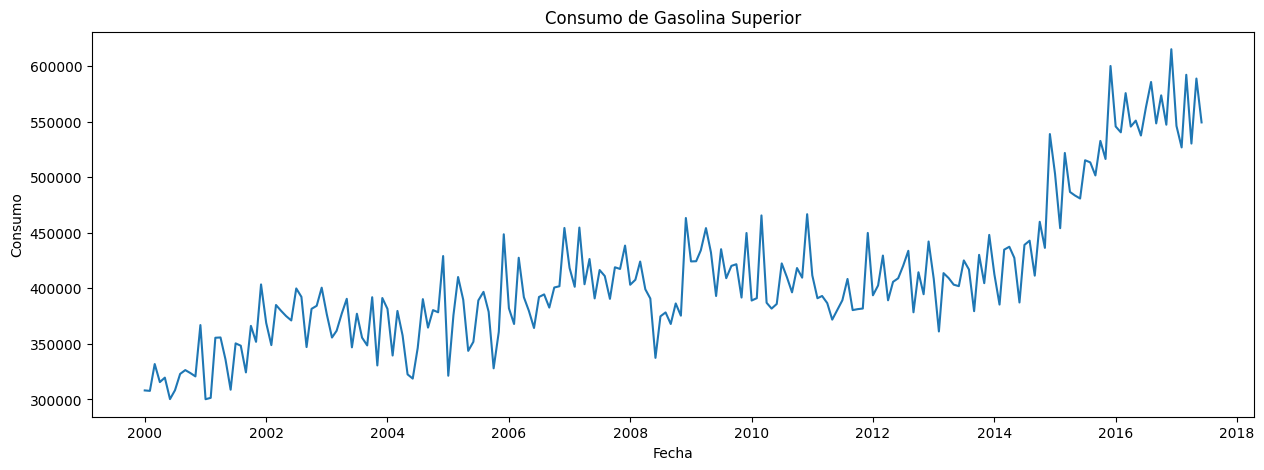

In [73]:
plt.plot(ts_consumo_superior)
plt.gca().set(title="Consumo de Gasolina Superior", xlabel="Fecha", ylabel="Consumo")
plt.show()

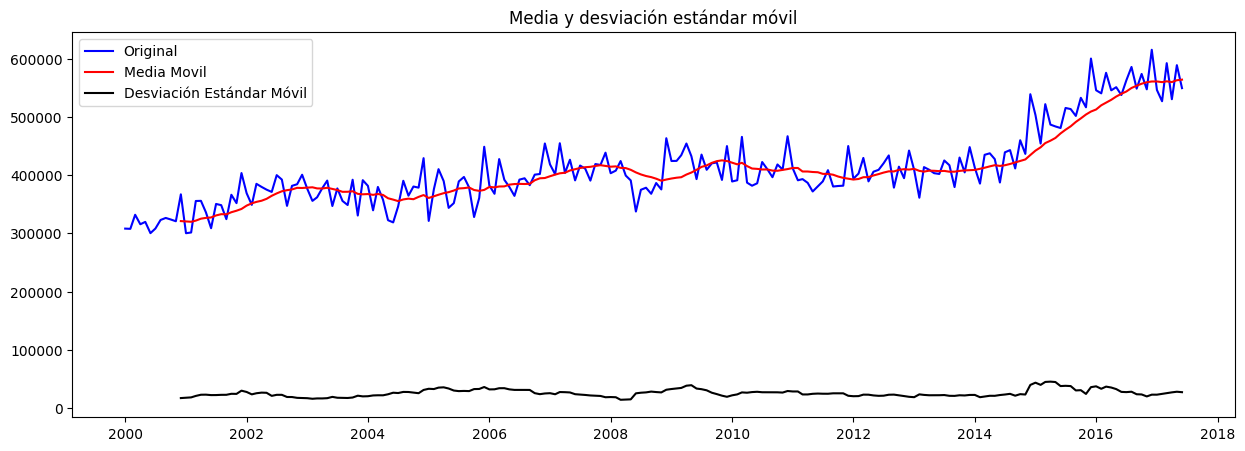

In [76]:
mediaMovil = ts_consumo_superior.rolling(window=12).mean()
deMovil = ts_consumo_superior.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(ts_consumo_superior, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

En la gráfica se observa que la serie del tiempo muestra una tendencia creciente, lo que indica que la media no es constante. La media móvil (línea roja) también va en aumento, reforzando la idea de que la serie probablemente no es estacionaria en media. 

Por otro lado, la desviación estándar no parece aumentar ni decrecer, la serie es estacionaria en varianza.

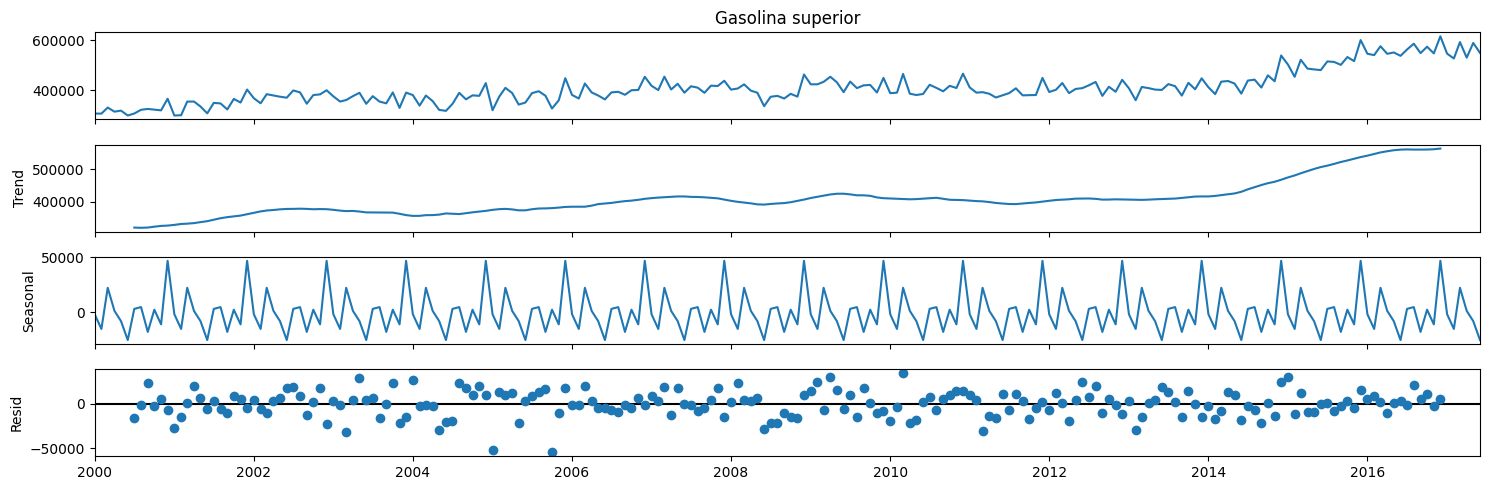

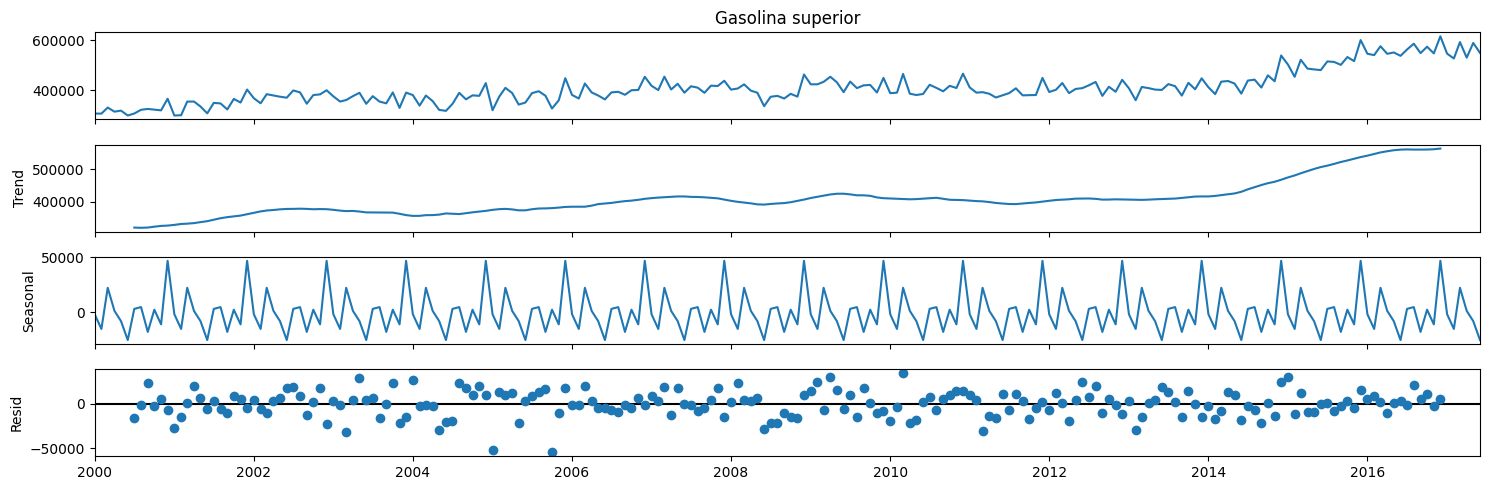

In [77]:
# DESCOMPOSICION ADITIVA
descomposicion = seasonal_decompose(ts_consumo_superior)
descomposicion.plot()

Conclusiones: 
- La serie no es estacionaria en media por la tendencia creciente. 
- La varianza parece ser estacionaria, ya que los residuos se dispersan de manera constante.
- Hay estacionalidad clara, lo que sirve para hacer modeos como SARIMA. 
- No será necesario aplicar transformaciones logarítmicas. 

#### Análisis inicial de la serie

Dado que la serie de tiempo no es estacionaria en media, se aplica una transformación logarítmica y la volvemos a graficar. 

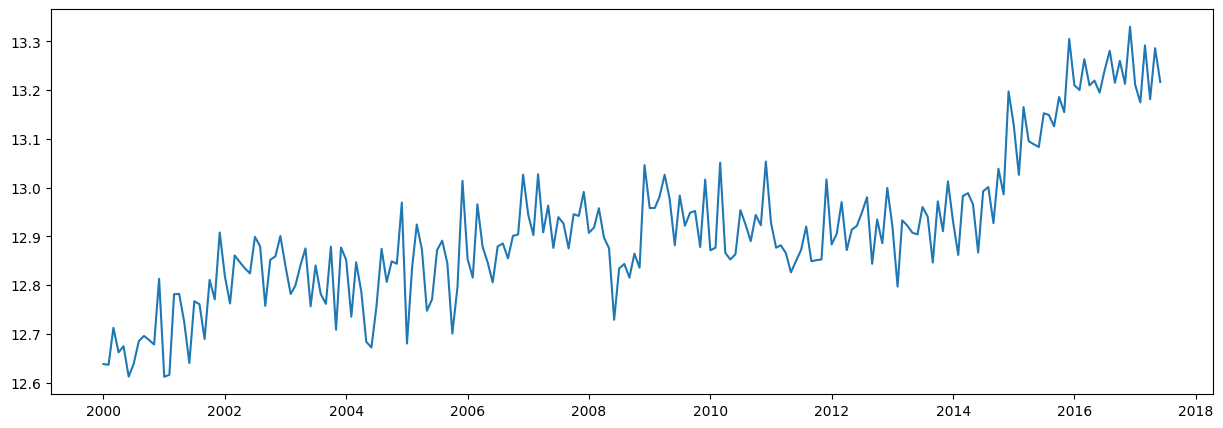

In [78]:
ts_consumo_superior_log = np.log(ts_consumo_superior)
plt.plot(ts_consumo_superior_log)

Con la transformación logarítmica se estacionarizó la varianza. Para validar si es estacionaria en media (que se ve que no es por el gráfico), se aplica la pruebea de Dickey fuller. 

- H₀ (nula): la serie no es estacionaria (tiene raíz unitaria).
- H₁ (alternativa): la serie sí es estacionaria.

In [79]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(ts_consumo_superior, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          0.211967
p-value                        0.972925
# de retardos usados          12.000000
# de observaciones usadas    197.000000
Critical Value (1%)           -3.463987
Critical Value (5%)           -2.876326
Critical Value (10%)          -2.574652
dtype: float64


Como el varlor-p es mayor a 0.05, la serie no es estacionaria en media. Hay que diferenciarla. 

In [80]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_consumo_superior_diff = ts_consumo_superior.diff()
ts_consumo_superior_diff.dropna(inplace=True)
dfTest = adfuller(ts_consumo_superior_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -4.469609
p-value                        0.000223
# de retardos usados          11.000000
# de observaciones usadas    197.000000
Critical Value (1%)           -3.463987
Critical Value (5%)           -2.876326
Critical Value (10%)          -2.574652
dtype: float64


El valor-p es menor a 0.05, por lo que la serie es estacionaria en media. Se Puede decir que el valor de **d = 1**. 

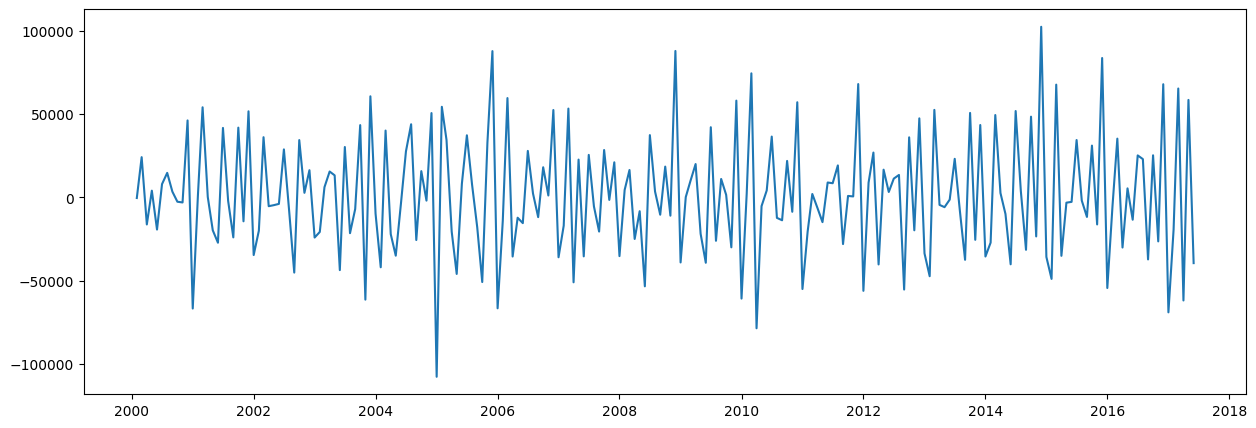

In [81]:
plt.plot(ts_consumo_superior_diff)

No es necesario hacer una transformación logarítmica, solamente diferenciarlo una vez. La serie diferenciada es estacinaria en media y en varianza.

#### Estimar los parámetros del modelo

In [82]:
ts_consumo_superior_diff.dropna(inplace = True)
tsa_acf = acf(ts_consumo_superior_diff,nlags=5,fft=False) #lag: cantidad de meses que me voy a saltar en la serie de tiempo
tsa_pacf = pacf(ts_consumo_superior_diff, nlags=36) #se recomienda el lag en múltiplos de 12 (por el año)
tsa_acf

array([ 1.        , -0.48388427, -0.09258392,  0.1125738 , -0.03897311,
        0.26347002])

In [83]:
tsa_pacf

array([ 1.        , -0.48621064, -0.43200572, -0.25908911, -0.22548618,
        0.30971028, -0.17029482, -0.08368773, -0.2351591 ,  0.10704826,
        0.00650634, -0.34845857,  0.31830561,  0.07281629,  0.07990626,
       -0.00272065,  0.00966734,  0.10065402, -0.10450289,  0.00371184,
       -0.08806175,  0.06712348, -0.06528197, -0.10178494,  0.17467489,
       -0.02069443,  0.04460801, -0.07537072,  0.00234058,  0.11117409,
       -0.14465045, -0.1446281 , -0.08645015, -0.03349498,  0.13886484,
       -0.16861824,  0.02001735])

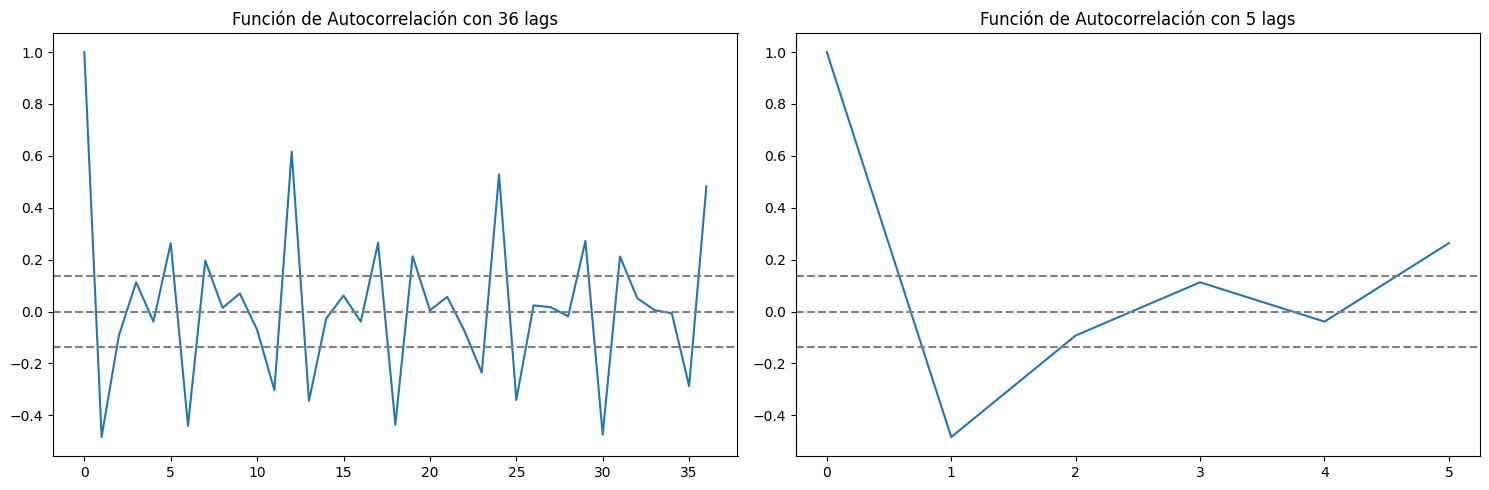

In [84]:

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(ts_consumo_superior_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_consumo_superior_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_consumo_superior_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 lags')

plt.subplot(122) 
plt.plot(acf(ts_consumo_superior_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_consumo_superior_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_consumo_superior_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 lags')

plt.tight_layout()

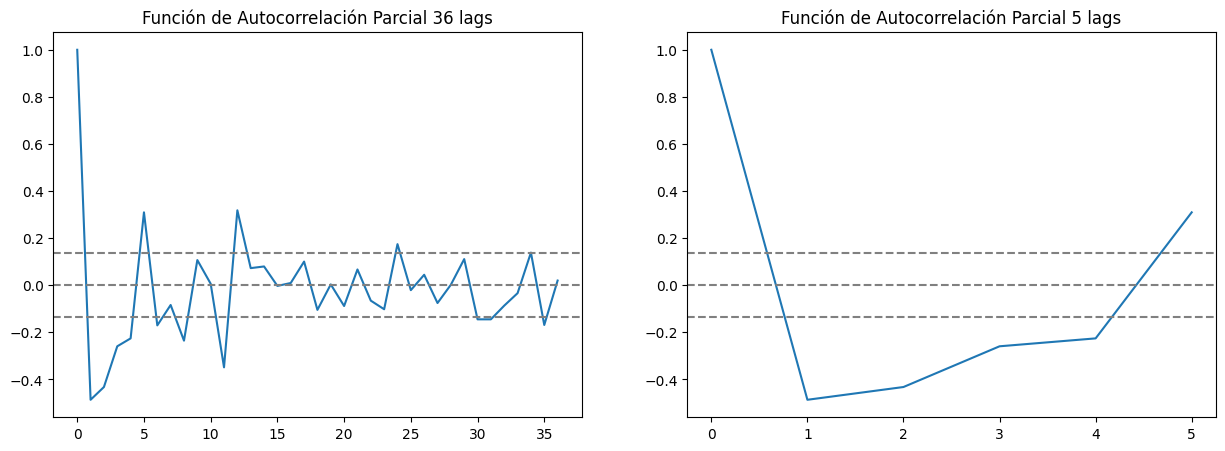

In [85]:
#plot PACF
plt.subplot(121)
plt.plot(pacf(ts_consumo_superior_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_consumo_superior_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_consumo_superior_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 lags')

plt.subplot(122)
plt.plot(pacf(ts_consumo_superior_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_consumo_superior_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_consumo_superior_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 lags')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Como se ve en los gráficos de autocorrelación y autocorrelación parcial, podemos intuir que se trata de un modelo teórico similar a un ARMA(p,q). Ambas gráficas decaen gradualmente. 

Se probarán los siguientes modelos: 
- p = 1, d = 1, q = 3
- p = 2, d = 1, q = 4

#### Estacionalidad

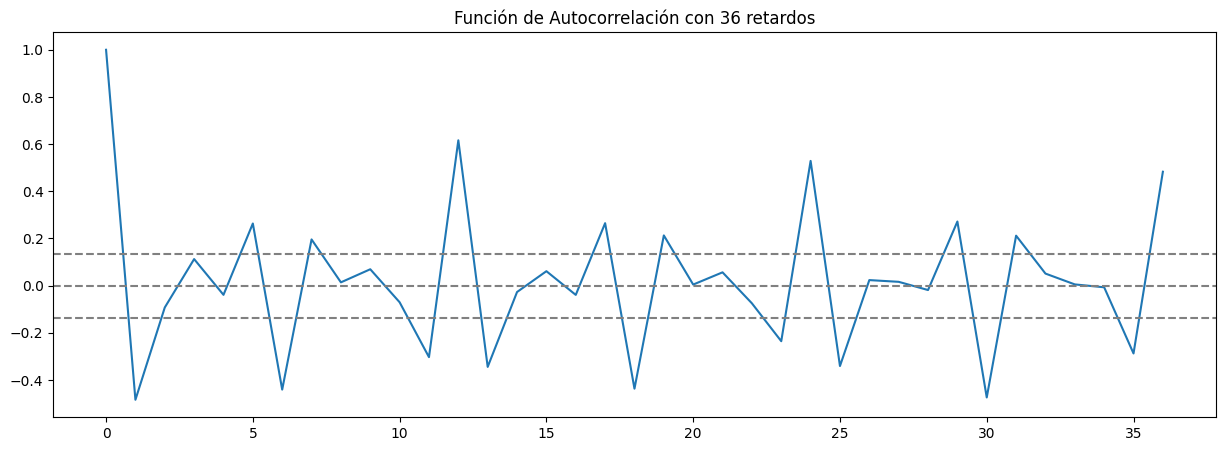

In [86]:
plt.plot(acf(ts_consumo_superior_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_consumo_superior_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_consumo_superior_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Como se ve en el gráfico, el comportamiento es similar para todas las estaciones, no se puede decirque haya estacionalidad cada 12 meses. No es necesario agregar el componente estacional. Se usa solo ARIMA.

#### Generación de modelos

In [87]:
modelo113 = ARIMA(ts_consumo_superior, order=(1,1,3))
resultado_m113 = modelo113.fit()
print(resultado_m113.summary().tables[1])

modelo214 = ARIMA(ts_consumo_superior, order=(2,1,4))
resultado_m214 = modelo214.fit()
print(resultado_m214.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6943      0.137     -5.080      0.000      -0.962      -0.426
ma.L1          0.1247      0.133      0.935      0.350      -0.137       0.386
ma.L2         -0.4932      0.099     -4.988      0.000      -0.687      -0.299
ma.L3          0.0835      0.051      1.634      0.102      -0.017       0.184
sigma2      7.957e+08   4.74e-11   1.68e+19      0.000    7.96e+08    7.96e+08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5192      2.751     -0.189      0.850      -5.911       4.873
ar.L2          0.1485      1.833      0.081      0.935      -3.444       3.741
ma.L1         -0.0527      2.754     -0.019      0.985      -5.450       5.344
ma.L2         -0.5449      0.345     -1.580      0.1

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.f

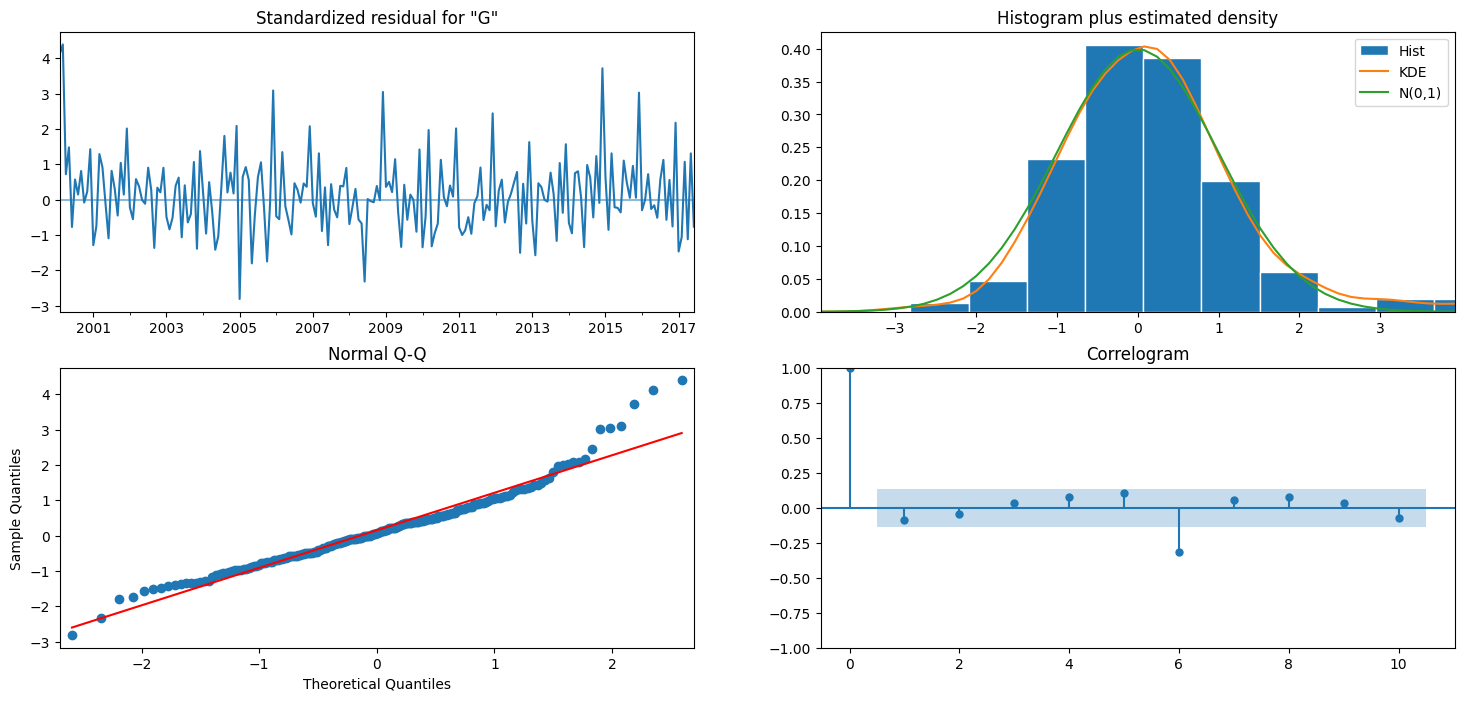

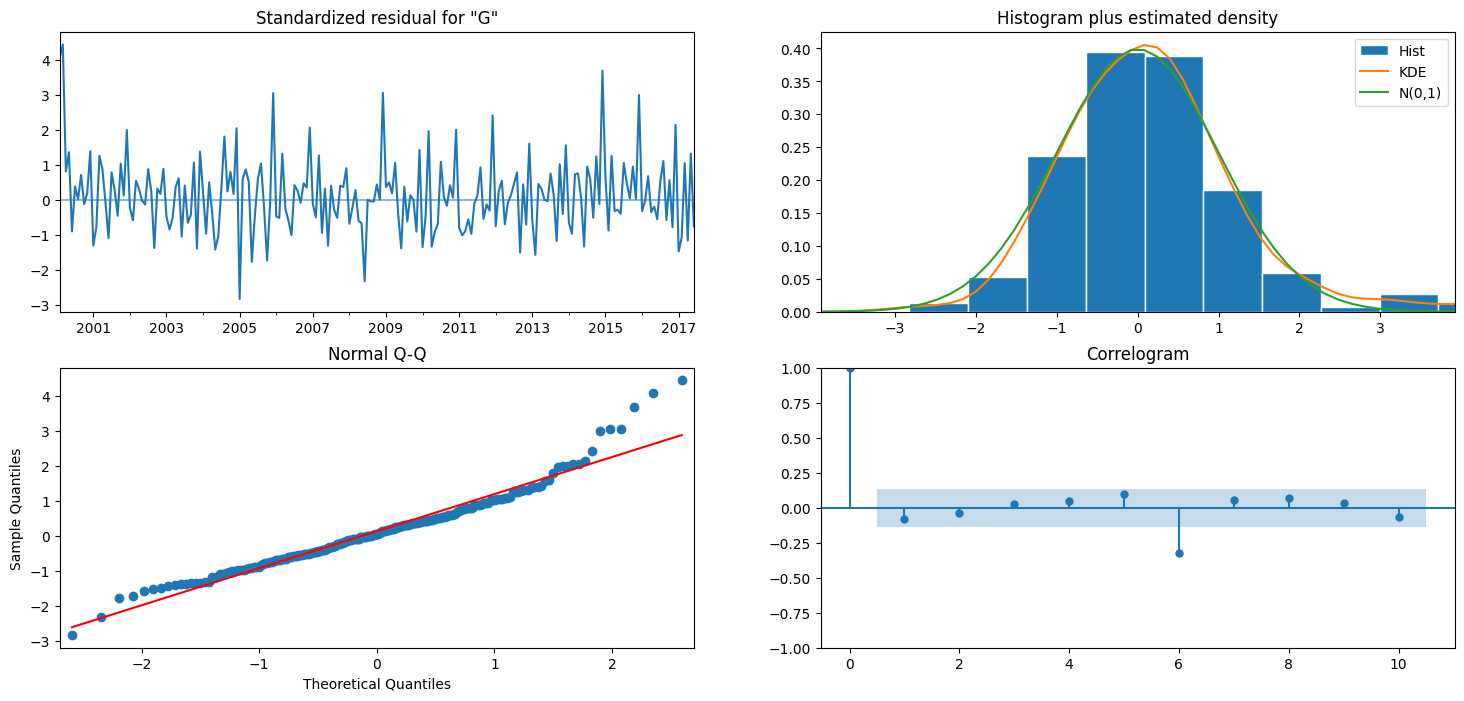

In [88]:
resultado_m113.plot_diagnostics(figsize=(18, 8))
plt.show()

resultado_m214.plot_diagnostics(figsize=(18, 8))
plt.show()

Como se puede observar (para ambos modelos): 
- El residuo estándar tiene ruidos distribuidos alrededor de 0. La varianza es constante.
- El histograma tiene una distribución normal y los errores también. 
- El correlograma mantiene los puntos en la zona de control la mayoría de casos. 

In [ ]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 113=",resultado_m113.aic)
print("Modelo 214=",resultado_m214.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 113=",resultado_m113.bic)
print("Modelo 214 =",resultado_m214.bic)


Resultados de AIC (Akaike information criterion)
Modelo 112= 4917.583616583051
Modelo 213= 4921.1407382397665
Resultados de BIC (Bayesian information criterion)
Modelo 112= 4934.295287842875
Modelo 213 = 4944.53707800352


De acuerdo a ambos indicadores, el mejor el modelo p = 1, d = 1, q = 3, aunque la diferencia es mínima. Este será usado para hacer las predicciones.

### 2. Importaciones Gasolina Superior

### 3. Consumo Gasolina Regular

### 4. Importaciones Gasolina Regular

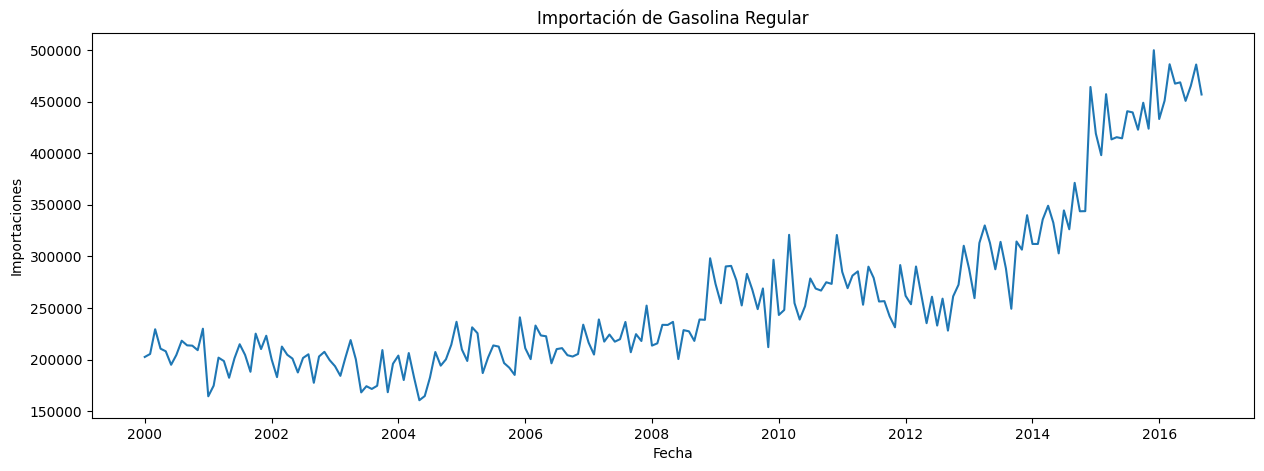

In [75]:
plt.plot(ts_importa_regular)
plt.gca().set(title="Importación de Gasolina Regular", xlabel="Fecha", ylabel="Importaciones")
plt.show()

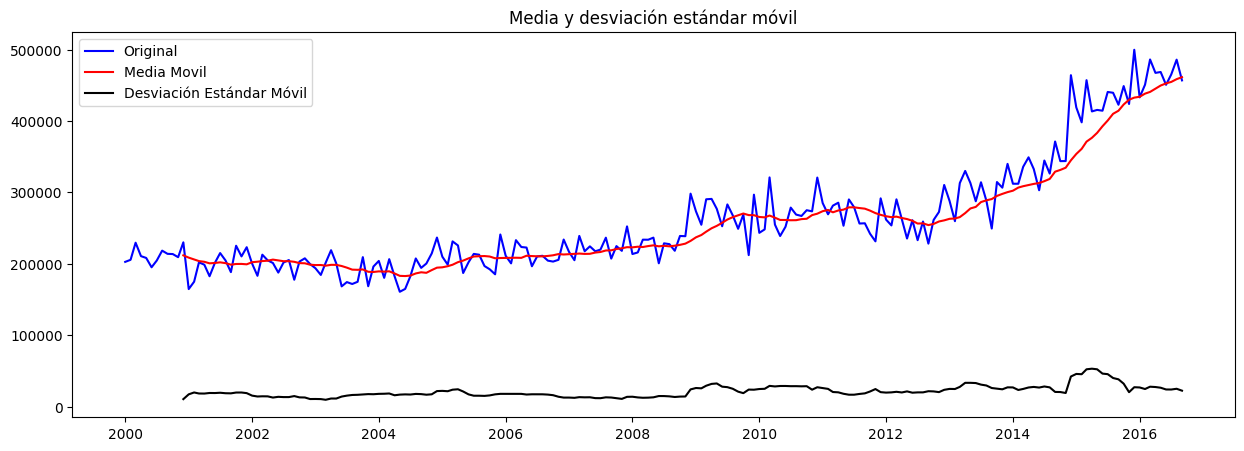

In [71]:
mediaMovil = ts_importa_regular.rolling(window=12).mean()
deMovil = ts_importa_regular.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(ts_importa_regular, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

En la gráfica se observa que la gráfica de la serie del tiempo muestra una tendencia creciente, lo que indica que la media no es constante. La media móvil (línea roja) también va en aumento, reforzando la idea de que la serie probablemente no es estacionaria en media. 

Por otro lado, la desviación estándar también parece aumentar a lo largo del tiempo, lo que indica que la serie puede no ser estacionaria en varianza.

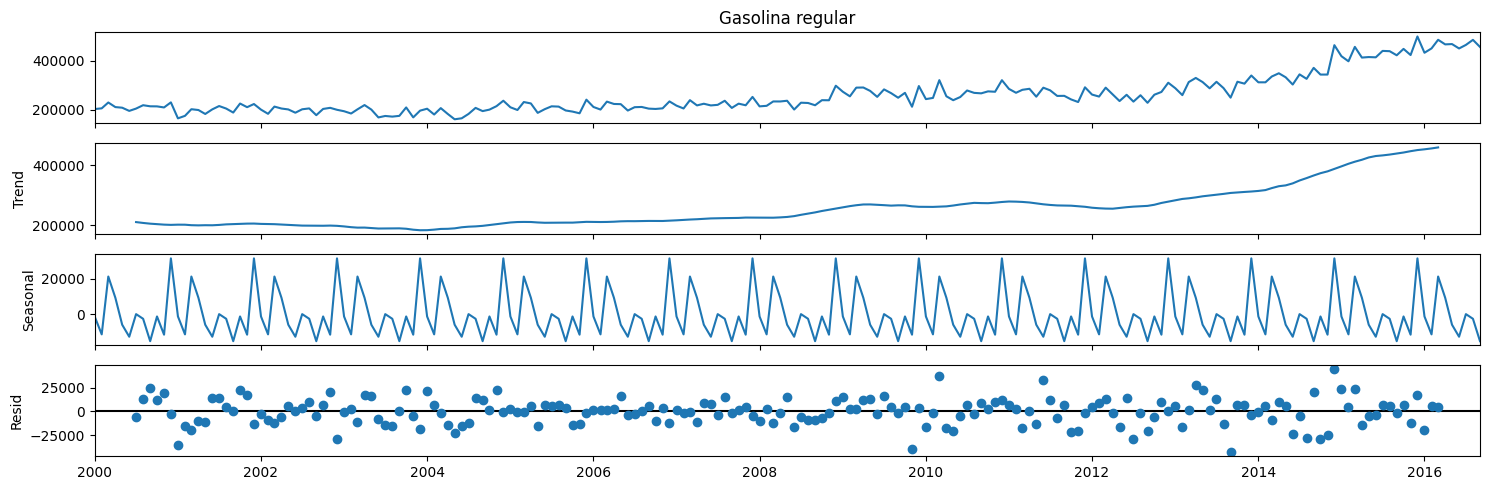

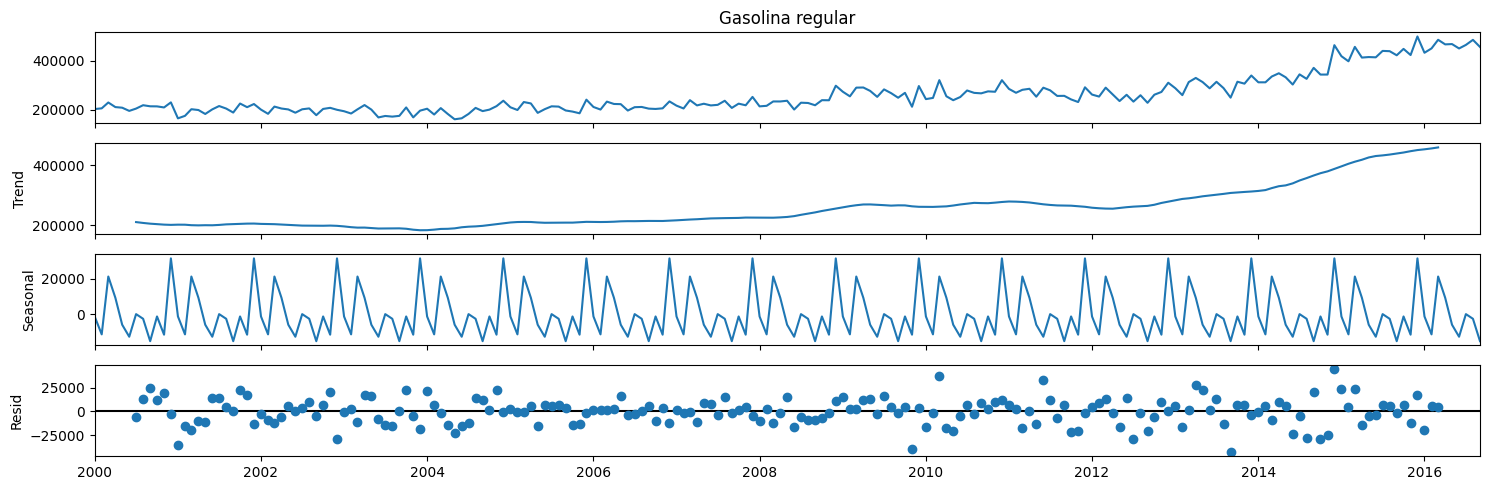

In [72]:
# DESCOMPOSICION ADITIVA
descomposicion = seasonal_decompose(ts_importa_regular)
descomposicion.plot()

Conclusiones: 
- La serie no es estacionaria en media por la tendencia creciente. 
- La varianza parece no ser estacionaria, ya que los residuos se dispersan más en el tiempo. 
- Hay estacionalidad clara, lo que sirve para hacer modeos como SARIMA. 
- Será necesario aplicar transformaciones logarítmicas. 

#### Análisis inicial de la serie

Dado que la serie de tiempo no es estacionaria en media, se aplica una transformación logarítmica y la volvemos a graficar. 

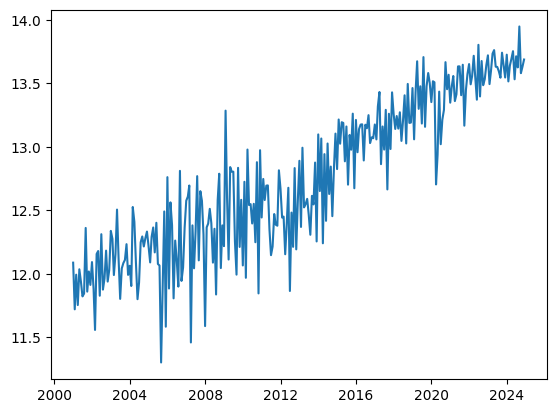

In [39]:
ts_importa_regular_log = np.log(ts_importa_regular)
plt.plot(ts_importa_regular_log)

Con la transformación logarítmica se estacionarizó la varianza. Para validar si es estacionaria en media (que se ve que no es por el gráfico), se aplica la pruebea de Dickey fuller. 

- H₀ (nula): la serie no es estacionaria (tiene raíz unitaria).
- H₁ (alternativa): la serie sí es estacionaria.

In [40]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(ts_importa_regular, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          0.830167
p-value                        0.992108
# de retardos usados           9.000000
# de observaciones usadas    278.000000
Critical Value (1%)           -3.454094
Critical Value (5%)           -2.871993
Critical Value (10%)          -2.572340
dtype: float64


Como el varlor-p es mayor a 0.05, la serie no es estacionaria en media. Hay que diferenciarla. 

In [41]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_importa_regular_diff = ts_importa_regular.diff()
ts_importa_regular_diff.dropna(inplace=True)
dfTest = adfuller(ts_importa_regular_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -1.021694e+01
p-value                      5.450377e-18
# de retardos usados         8.000000e+00
# de observaciones usadas    2.780000e+02
Critical Value (1%)         -3.454094e+00
Critical Value (5%)         -2.871993e+00
Critical Value (10%)        -2.572340e+00
dtype: float64


El valor-p es menor a 0.05, por lo que la serie es estacionaria en media. Se Puede decir que el valor de **d = 1**. 

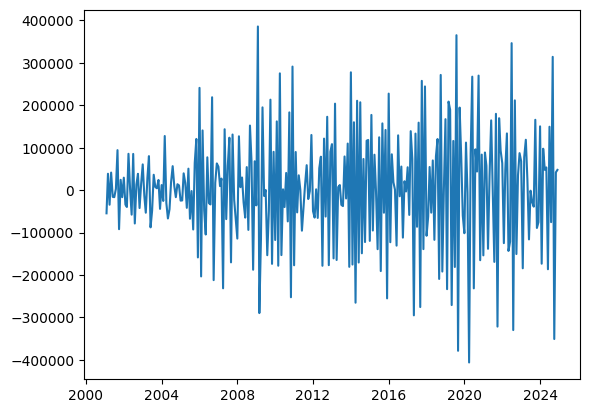

In [42]:
plt.plot(ts_importa_regular_diff)

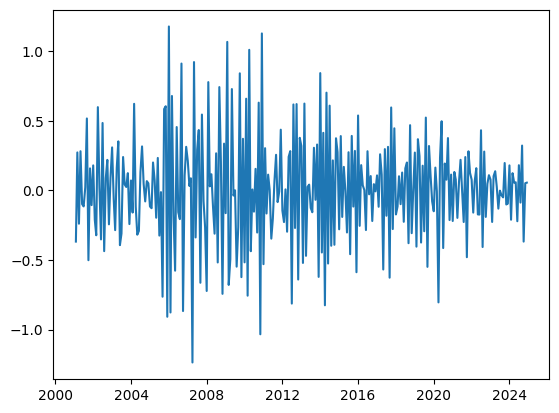

In [43]:
plt.plot(ts_importa_regular_log.diff())

Las transformaciones realizadas fueron una transformcaión logarítmica y una diferenciación. Se puede ver que la serie ya es estacionaria en media y en varianza. 

#### Estimar los parámetros del modelo

In [44]:
ts_importa_regular_log_diff = ts_importa_regular_log.diff()
ts_importa_regular_log_diff.dropna(inplace = True)
tsa_acf = acf(ts_importa_regular_log_diff,nlags=5,fft=False) #lag: cantidad de meses que me voy a saltar en la serie de tiempo
tsa_pacf = pacf(ts_importa_regular_log_diff, nlags=36) #se recomienda el lag en múltiplos de 12 (por el año)
tsa_acf

array([ 1.        , -0.63966623,  0.22911711, -0.1405702 ,  0.05703576,
        0.03591098])

In [45]:
tsa_pacf

array([ 1.00000000e+00, -6.41902825e-01, -3.08378209e-01, -2.74842446e-01,
       -2.55190438e-01, -1.04414784e-01, -4.87827218e-02, -2.49476378e-01,
       -1.10623363e-01, -1.97833156e-01, -1.30457232e-01, -7.20095422e-02,
        2.07260011e-02, -1.70872739e-01, -9.89847868e-02, -6.55350190e-02,
        9.39243570e-03,  9.90239468e-02, -1.52959259e-01, -1.51328189e-01,
       -3.87468688e-02, -4.03854674e-02,  3.29042316e-03, -4.75916502e-02,
       -9.53080899e-02, -1.23381030e-01, -2.41499327e-02, -3.36223088e-06,
        4.88025780e-02, -2.89457067e-02,  9.77574240e-02, -6.45291839e-02,
        1.82195668e-02,  2.81517348e-02, -2.40473435e-01,  1.48679387e-01,
        2.27077613e-02])

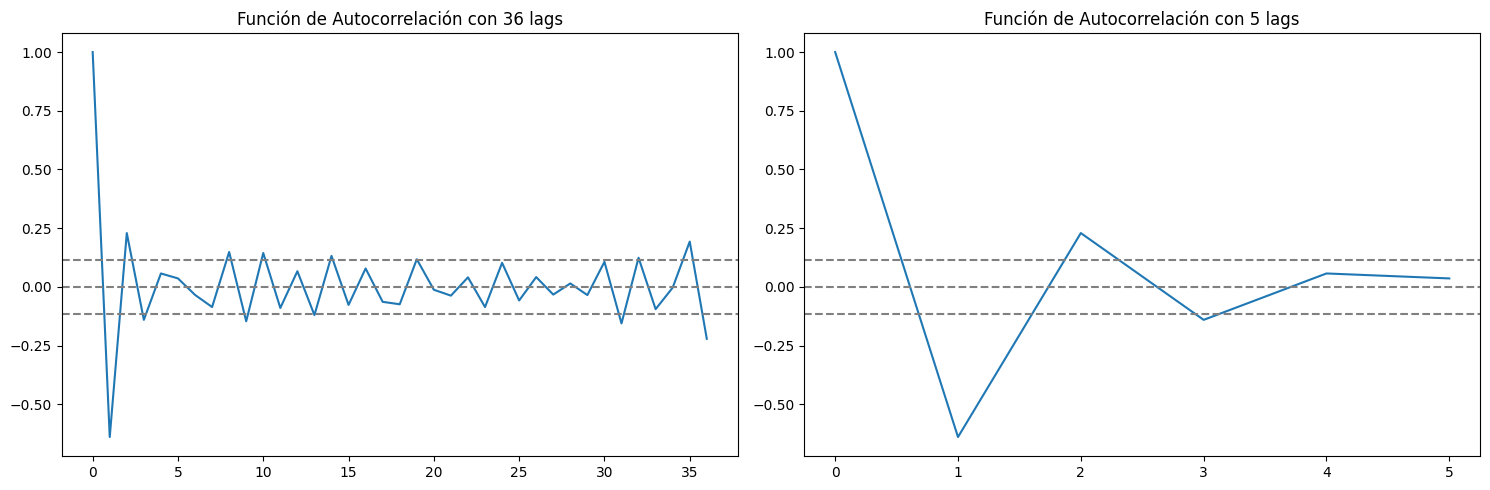

In [46]:

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(ts_importa_regular_log_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_importa_regular_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_importa_regular_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 lags')

plt.subplot(122) 
plt.plot(acf(ts_importa_regular_log_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_importa_regular_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_importa_regular_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 lags')

plt.tight_layout()

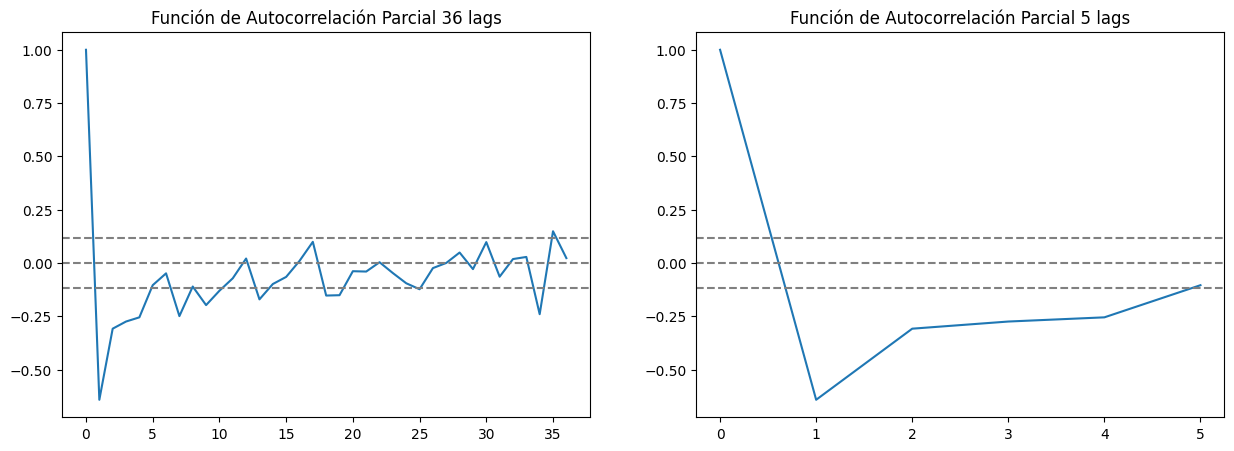

In [47]:
#plot PACF
plt.subplot(121)
plt.plot(pacf(ts_importa_regular_log_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_importa_regular_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_importa_regular_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 lags')

plt.subplot(122)
plt.plot(pacf(ts_importa_regular_log_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_importa_regular_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_importa_regular_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 lags')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Como se ve en los gráficos de autocorrelación y autocorrelación parcial, podemos intuir que se trata de un modelo teórico similar a un ARMA(p,q). Ambas gráficas decaen gradualmente. 

Se probarán los siguientes modelos: 
- p = 1, d = 1, q = 2
- p = 2, d = 1, q = 3

#### Estacionalidad

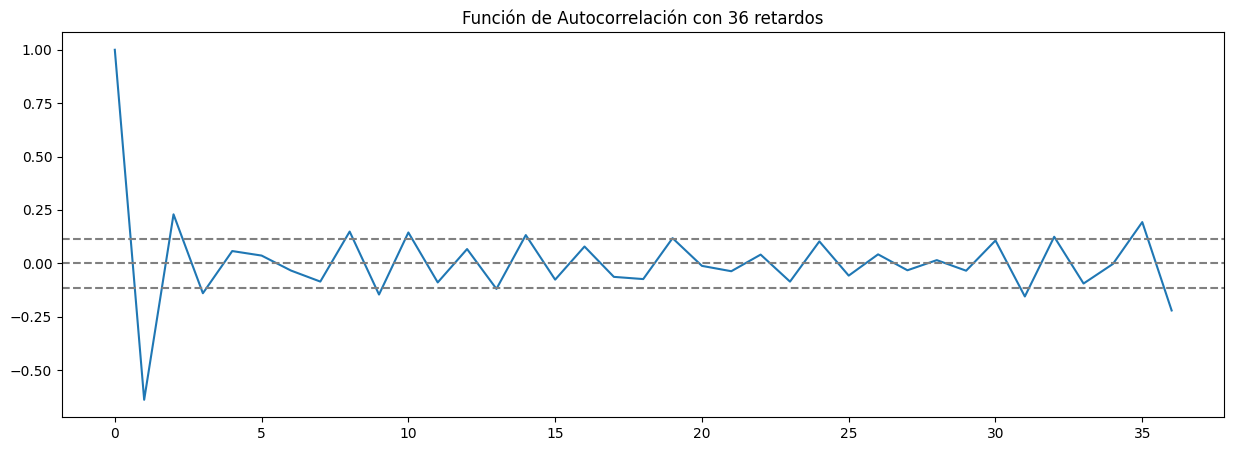

In [48]:
plt.plot(acf(ts_importa_regular_log_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_importa_regular_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_importa_regular_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Como se ve en el gráfico, el comportamiento es similar para todas las estaciones, no se puede decirque haya estacionalidad cada 12 meses. No es necesario agregar el componente estacional. Se usa solo ARIMA.

#### Generación de modelos

In [60]:
modelo112 = ARIMA(ts_importa_regular_log, order=(1,1,2))
resultado_m112 = modelo112.fit()
print(resultado_m112.summary().tables[1])

modelo213 = ARIMA(ts_importa_regular_log, order=(2,1,3))
resultado_m213 = modelo213.fit()
print(resultado_m213.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5351      0.190     -2.820      0.005      -0.907      -0.163
ma.L1         -0.5270      0.208     -2.539      0.011      -0.934      -0.120
ma.L2         -0.2651      0.190     -1.398      0.162      -0.637       0.106
sigma2         0.0674      0.005     13.910      0.000       0.058       0.077
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1180      0.130     -8.590      0.000      -1.373      -0.863
ar.L2         -0.7333      0.098     -7.449      0.000      -0.926      -0.540
ma.L1          0.1329      0.126      1.055      0.292      -0.114       0.380
ma.L2         -0.1034      0.107     -0.966      0.334      -0.313       0.106
ma.L3         -0.6519      0.083     -7.813      0.0

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.f

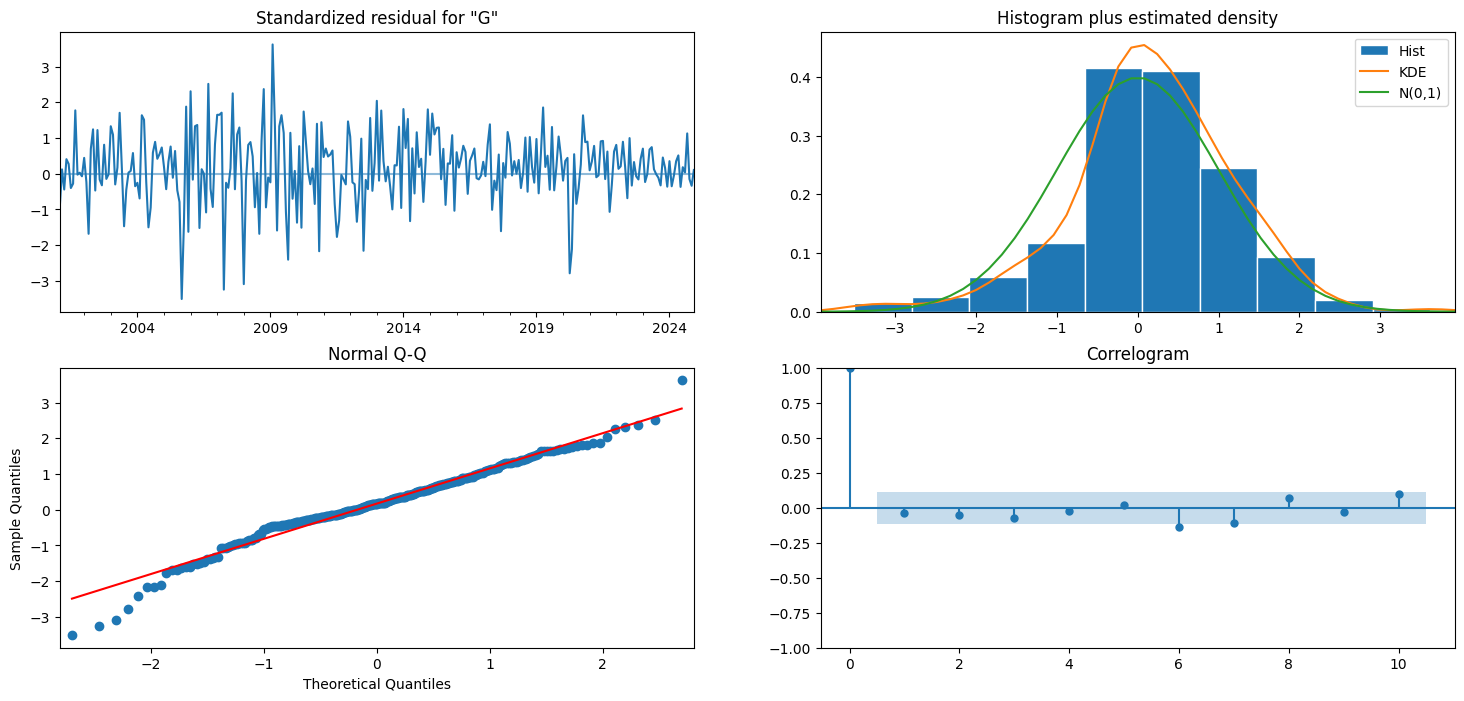

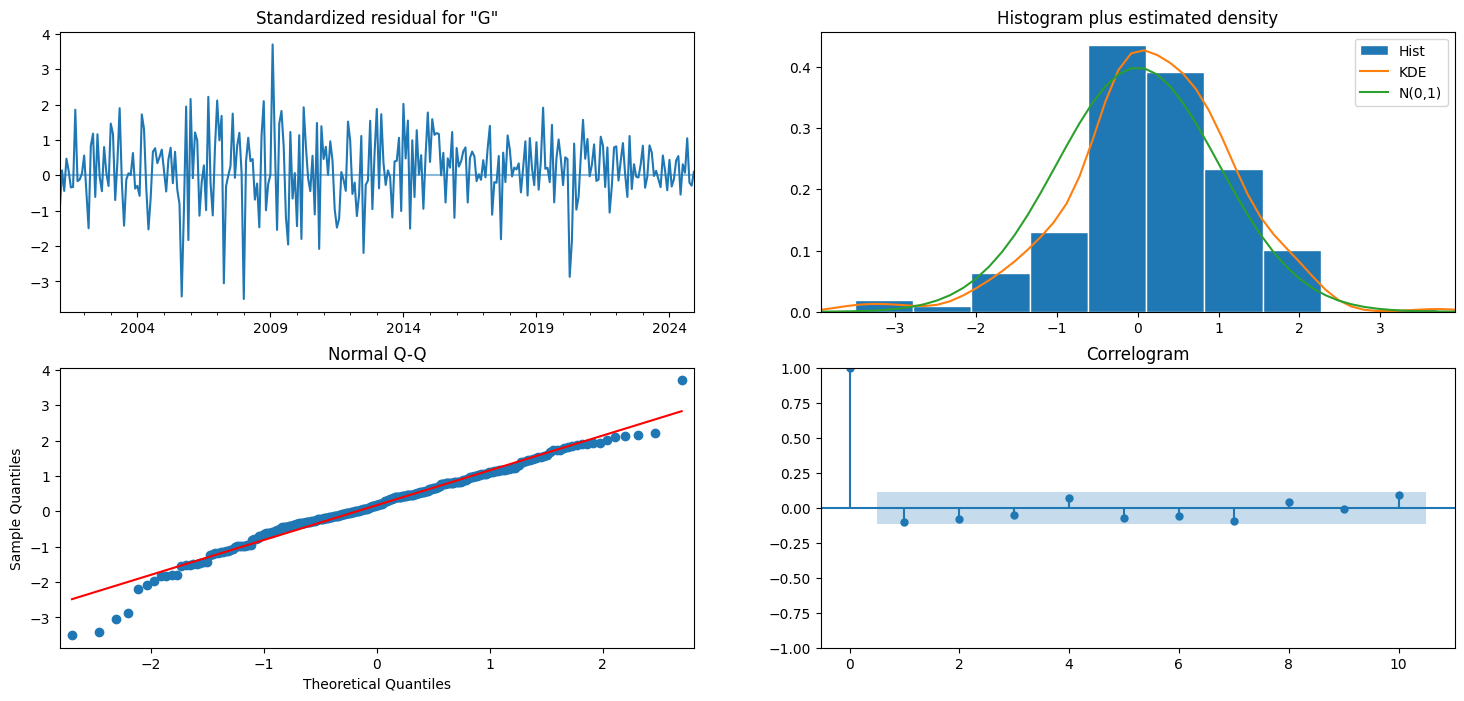

In [62]:
resultado_m112.plot_diagnostics(figsize=(18, 8))
plt.show()

resultado_m213.plot_diagnostics(figsize=(18, 8))
plt.show()

Como se puede observar (para ambos modelos): 
- El residuo estándar tiene ruidos distribuidos alrededor de 0. Aunque el patrón no es claro, se ve varianza más grande al inicio de la serie. 
- El histograma tiene una distribución normal y los errores también. 
- El correlograma mantiene los puntos en la zona de control. 

In [64]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 112=",resultado_m112.aic)
print("Modelo 213=",resultado_m213.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 112=",resultado_m112.bic)
print("Modelo 213 =",resultado_m213.bic)


Resultados de AIC (Akaike information criterion)
Modelo 112= 49.874288302204
Modelo 213= 51.63534456258055
Resultados de BIC (Bayesian information criterion)
Modelo 112= 64.51221716524249
Modelo 213 = 73.59223785713829


De acuerdo a ambos indicadores, el mejor el modelo p = 1, d = 1, q = 2, por lo que este será usado para hacer las predicciones.

### 5. Consumo Diesel

### 6. Importaciones Diesel